## Implementation of paper
### LEARNING TO PROTECT COMMUNICATIONS WITH ADVERSARIAL NEURAL CRYPTOGRAPHY

1. Model
- one 2n x 2n FC layer
- 4 convolutional layers with [kernel size, in channel, out channel, padding, stride] as below :
- [4,1,1,2,1]     
    [4,1,4,2,2]    
    [2,4,4,0,1]    
    [1,4,1,0,1]   


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class Communicators(torch.nn.Module):
    def __init__(self, N):              # N is number of dimensions.
        super(Communicators, self).__init__()
        self.fc_layer = torch.nn.Linear(2*N, 2*N)   # N bit values, N key values.
        # then we need 4 convolutional layers, such that after 4 convolutions output must be of size N.
        # output is the ciphertext.

        self.conv1 = torch.nn.Conv1d(in_channels=1 , out_channels=1, kernel_size=4, padding=2)
        # Size wont change it will remain exactly same.

        self.conv2 = torch.nn.Conv1d(in_channels=1, out_channels=4, kernel_size=4, padding=2, stride = 2)
        # Size will be half x 4.

        self.conv3 = torch.nn.Conv1d(in_channels=4, out_channels=4, kernel_size=2, stride = 1)
        # Size will be same.

        self.conv4 = torch.nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride = 1)
        # final size is N x 1.
    
    def forward(self, x):
        x = x[None, :, :].transpose(0, 1)
        x = self.fc_layer(x)
        x = F.sigmoid(x)
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        x = self.conv4(x)
        x = F.tanh(x)
        #binary_output = torch.where(x > 0, torch.tensor(1), torch.tensor(0))
        
        return torch.squeeze(x)


In [11]:
class adversary(torch.nn.Module):
    def __init__(self, N):
        super(adversary, self).__init__()
        self.fc_layer = torch.nn.Linear(N, 2*N)  # N bit encrypted values as input.
        self.conv1 = torch.nn.Conv1d(in_channels=1 , out_channels=1, kernel_size=4, padding=2)
        self.conv2 = torch.nn.Conv1d(in_channels=1, out_channels=4, kernel_size=4, padding=2, stride = 2)
        self.conv3 = torch.nn.Conv1d(in_channels=4, out_channels=4, kernel_size=2, stride = 1)
        self.conv4 = torch.nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride = 1)

    def forward(self, x):
        x = x[None, :, :].transpose(0, 1)
        x = self.fc_layer(x)
        x = F.sigmoid(x)
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        x = self.conv4(x)
        x = F.tanh(x)
        #binary_output = torch.where(x > 0, torch.tensor(1), torch.tensor(0))
        # binary_output = x
        return torch.squeeze(x)

In [12]:
def get_binary_data(batch,len):
    binary_input = (2*torch.randint(low = 0, high = 2, size = (batch, len)) - 1).float() 
    binary_input.requires_grad_(True)
    return binary_input

In [13]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []

def train(batch_size, lr, iterations, size):
    #defining some hyperparameters.
    batch_size = batch_size     # 256 - 4096. # paper used 4096
    lr = lr                     # as per the paper.
    iterations = iterations     # paper used 25000
    size = size                 # size of the input data.


    alice = Communicators(size)
    bob = Communicators(size)
    eve = adversary(size)
    
    alice.train()
    bob.train()
    eve.train()


    #optimisers
    optimser_alice = Adam(params = alice.parameters(), lr = lr)
    optimser_bob = Adam(params = bob.parameters(), lr = lr)
    optimser_eve = Adam(params = eve.parameters(), lr = lr)

    for i in range(iterations):
        # train alice and bob 1 time.
        
        plain = get_binary_data(batch_size, size)
        key = get_binary_data(batch_size, size)

        alice_c = alice.forward(torch.cat((plain, key), dim = 1))
        # print(alice_c.shape)
        bob_p = bob.forward(torch.cat((alice_c, key), dim = 1))
        eve_p = eve.forward(alice_c)

        # loss functions page no. 6.
        error_bob = nn.L1Loss()(bob_p, plain)/2.0
        error_eve = nn.L1Loss()(eve_p, plain)/2.0
        ab_loss = error_bob + (1.0 - error_eve*2)**2

        optimser_alice.zero_grad()
        optimser_bob.zero_grad()
        ab_loss.backward()
        #clipping the gradients is not done.

        optimser_alice.step()
        optimser_bob.step()

        # train eve 2 times.
        for j in range(2):
            plain = get_binary_data(batch_size,size)
            key = get_binary_data(batch_size,size)
            alice_c = alice.forward(torch.cat((plain, key), dim = 1))
            eve_p = eve.forward(alice_c)

            error_eve = nn.L1Loss()(eve_p, plain)/2.0
            optimser_eve.zero_grad()
            error_eve.backward()
            #clipping the gradients is not done.
            optimser_eve.step()
        
        steps.append(i)
        plain = get_binary_data(batch_size,size)
        key = get_binary_data(batch_size,size)
        alice_c = alice.forward(torch.cat((plain, key), dim = 1))
        bob_p = bob.forward(torch.cat((alice_c, key), dim = 1))
        eve_p = eve.forward(alice_c)

        error_bob = (nn.L1Loss()(bob_p, plain))/2.0
        error_eve = (nn.L1Loss()(eve_p, plain))/2.0

        bob_rc_error.append(error_bob.item())
        eve_rc_error.append(error_eve.item())
        ab_loss = error_bob + (1.0 - error_eve*2)**2
        ab_error.append(ab_loss.item())
        
        if i%1000 == 0:
            print("Iteration: ", i, "  Bob Loss: ", error_bob.item())
            print("Iteration: ", i, "  Eve Loss: ", error_eve.item())



    # in each iteration we will train alice,bob once and eve 2 times.

In [14]:
import matplotlib.pyplot as plt

#change the size to 20, 10
def plot_it(steps, bob_rc_error, eve_rc_error):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Reconstruction Error")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Reconstruction Error")
    ax.plot(steps, bob_rc_error, label = "Bob")
    ax.plot(steps, eve_rc_error, label = "Eve")
    ax.legend()

    plt.show()

# plt.plot(steps, bob_rc_error, label = "Bob")
# plt.plot(steps, eve_rc_error, label = "Eve")
# plt.xlabel("Iterations")
# plt.ylabel("Reconstruction Error")
# plt.legend()

# plt.show()

In [15]:
def plot_it2(steps, eve_error, ab_error):
   fig = plt.figure(figsize=(20,10))
   ax = fig.add_subplot(1,1,1)
   ax.set_title("Reconstruction Error")
   ax.set_xlabel("Iterations")
   ax.set_ylabel("Reconstruction Error")
   ax.plot(steps, eve_error, label = "Eve")
   ax.plot(steps, ab_error, label = "alice-bob")
   ax.legend()

   plt.show()

In [16]:
train(batch_size = 256, lr = 0.0008, iterations = 25000, size = 16)

Iteration:  0   Bob Loss:  0.5005335211753845
Iteration:  0   Eve Loss:  0.5006347298622131
Iteration:  1000   Bob Loss:  0.4982665479183197
Iteration:  1000   Eve Loss:  0.49736031889915466
Iteration:  2000   Bob Loss:  0.49896523356437683
Iteration:  2000   Eve Loss:  0.498688280582428
Iteration:  3000   Bob Loss:  0.5004124641418457
Iteration:  3000   Eve Loss:  0.5003645420074463
Iteration:  4000   Bob Loss:  0.5003403425216675
Iteration:  4000   Eve Loss:  0.5002805590629578
Iteration:  5000   Bob Loss:  0.501527726650238
Iteration:  5000   Eve Loss:  0.5016785860061646
Iteration:  6000   Bob Loss:  0.4985300302505493
Iteration:  6000   Eve Loss:  0.49793004989624023
Iteration:  7000   Bob Loss:  0.24121716618537903
Iteration:  7000   Eve Loss:  0.39069440960884094
Iteration:  8000   Bob Loss:  0.13889184594154358
Iteration:  8000   Eve Loss:  0.40289589762687683
Iteration:  9000   Bob Loss:  0.07998553663492203
Iteration:  9000   Eve Loss:  0.4064751863479614
Iteration:  10000   

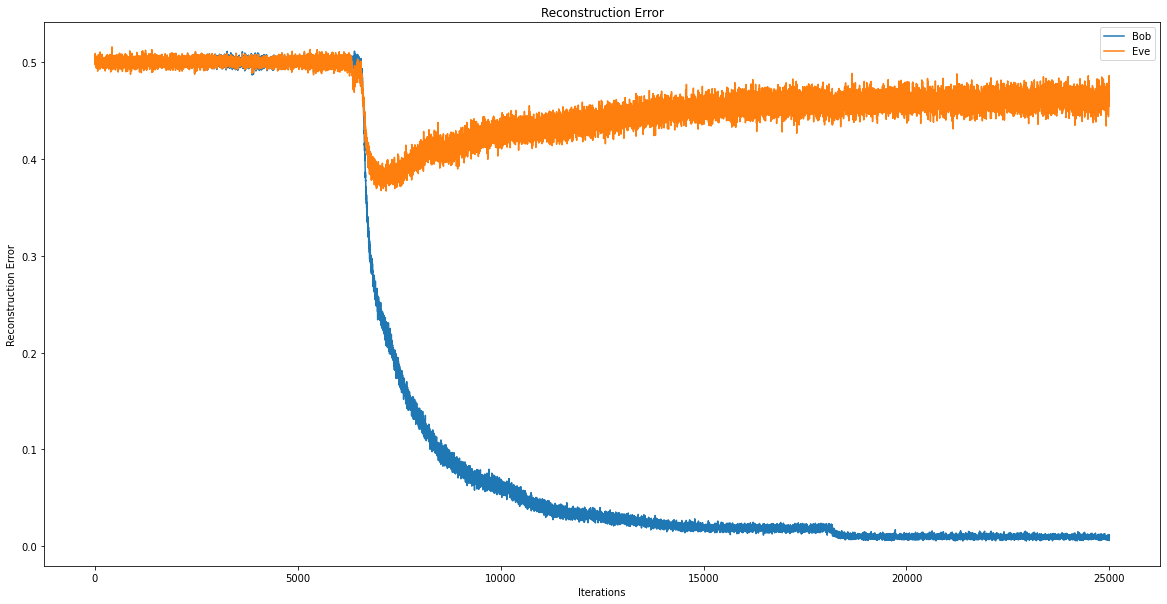

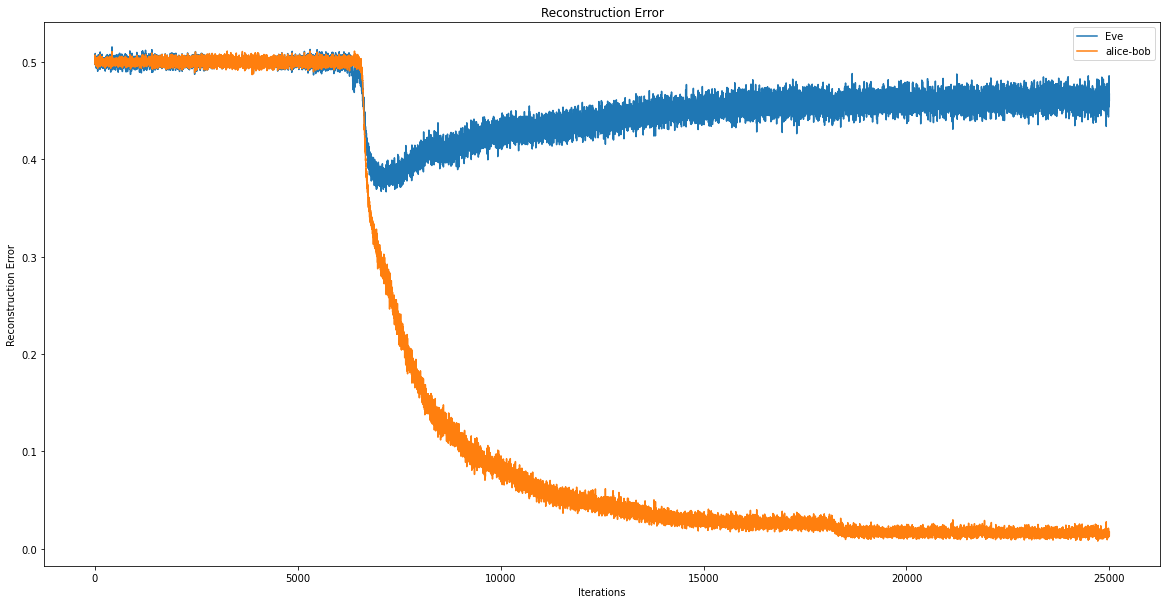

In [17]:
plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)